# Mission - Classifiez automatiquement des informations
# Partie 1 - Identifiez les causes d'attrition au sein d'une ESN

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

## Étape 2 - Préparez la donnée pour la modélisation

#### Importation des librairies

In [2]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display

# Librairies scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

### On reprend les éléments du précédent notebook

In [3]:
donnees_features = pd.read_csv("../Data/Projet_4_etape1_clean.csv")

#### Petit check

In [4]:
donnees_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   age                                       1470 non-null   int64 
 1   genre                                     1470 non-null   object
 2   revenu_mensuel                            1470 non-null   int64 
 3   statut_marital                            1470 non-null   object
 4   poste                                     1470 non-null   object
 5   nombre_experiences_precedentes            1470 non-null   int64 
 6   annee_experience_totale                   1470 non-null   int64 
 7   annees_dans_l_entreprise                  1470 non-null   int64 
 8   satisfaction_employee_environnement       1470 non-null   int64 
 9   satisfaction_employee_nature_travail      1470 non-null   int64 
 10  heure_supplementaires                     1470 n

* Petit récapitulatif

In [5]:
shape_donnees_features = donnees_features.shape
print("Nous avons", shape_donnees_features[0],"lignes et",shape_donnees_features[1],"colonnes avant transformation")

Nous avons 1470 lignes et 19 colonnes avant transformation


#### On vérifie l'importation

In [6]:
donnees_features.head()

,age,genre,revenu_mensuel,statut_marital,poste,nombre_experiences_precedentes,annee_experience_totale,annees_dans_l_entreprise,satisfaction_employee_environnement,satisfaction_employee_nature_travail,heure_supplementaires,augmentation_salaire_precedente_pourcent,a_quitte_l_entreprise,nombre_participation_pee,nb_formations_suivies,distance_domicile_travail,niveau_education,frequence_deplacement,annees_depuis_la_derniere_promotion
0,41,F,5993,Celibataire,CadreCommercial,8,8,6,2,4,Oui,11,Oui,0,0,1,2,Occasionnel,0
1,49,M,5130,Marie,AssistantdeDirection,1,10,10,3,2,Non,23,Non,1,3,8,1,Frequent,1
2,37,M,2090,Celibataire,Consultant,6,7,0,4,3,Oui,15,Oui,0,3,2,2,Occasionnel,0
3,33,F,2909,Marie,AssistantdeDirection,1,8,8,4,3,Oui,11,Non,0,3,3,4,Frequent,3
4,27,M,3468,Marie,Consultant,9,6,2,1,2,Non,12,Non,1,3,2,1,Occasionnel,2


#### Regardons la distribution de notre variable continue revenu_mensuel

In [7]:
fig13 = px.histogram(
    donnees_features, x='revenu_mensuel', color ='a_quitte_l_entreprise'
)
fig13.show()
pio.write_image(fig13,"../Graph/graph_etape_2/Histo_Cible_cible_enviro.png")

* La distribution du revenu_mensuel n'est pas linéaire, on voit un étalement sur la droite. L'explication peut être simplement un écart de revenu conséquent avec les différents types de poste. Regardons de plus près avec un boxplot de cette variable.

In [8]:
fig14 = px.box(
        donnees_features,
        x='revenu_mensuel',
        title=f"Boxplot interactif - Cible et revenu",
        hover_data = "a_quitte_l_entreprise"
     
    )
fig14.update_layout(height=500, width=600)
fig14.show()
pio.write_image(fig14, "../Graph/graph_etape_2/Boxplot_cible_revenu_mensuel.png")

* On remarque quelques valeurs extrêmes, elles semblent normales avec les petites analyses que nous avons réalisé dans l'étape précédente. On peut le confirmer en regardant via une méthode statistique plus poussée.

#### Nous ne pouvons pas utiliser ici la méthode du z-score car nous n'avons pas une distribution normale. Regardons avec la méthode IQR.

L'écart interquartile (IQR) est une mesure de la dispersion, basée sur la division de l'ensemble de données en quartiles. Les quartiles divisent un ensemble de données classé en quatre parties égales.
Ici on va appliquer un calcul sur l'IQR, limite haute et basse pour identifier des valeurs abrérrantes/extrêmes.
* inférieures à Q1 - 1,5 * IQR 
* ou supérieures à Q3 + 1,5 * IQR 

In [9]:
# J'applique la méthode à ma variable
iqr = np.quantile(donnees_features['revenu_mensuel'], q=[0.25, 0.75])
limite_basse = iqr[0] - 1.5*(iqr[1]-iqr[0])
limite_haute = iqr[1] + 1.5*(iqr[1]-iqr[0])

In [10]:
print("La limite haute est de",limite_haute,"et la limite basse est de",limite_basse)

La limite haute est de 16581.0 et la limite basse est de -5291.0


#### Recherchons quels sont les postes avec de si gros salaires

In [11]:
(donnees_features['revenu_mensuel']>=limite_haute).value_counts()

revenu_mensuel
False    1356
True      114
Name: count, dtype: int64

In [12]:
donnees_features.loc[donnees_features['revenu_mensuel']>=limite_haute,'poste'].unique()

array(['SeniorManager', 'DirecteurTechnique'], dtype=object)

* Rien d'étonnant ici, les salaires au-dessus de 16 581 sont des directeurs, nous pouvons les garder dans notre jeu.
* Pour la limite basse, pas besoin de recherches complémentaires car nous n'avons de salaire négatif dans notre DataFrame.

Analyse globale (pas distinction de Oui et Non) les autres variables quantitatives (à partir des éléments de l'étape 1) :
* age : Nous asvon vu dans l'étape précédente que les âges allaient de 18 à 60 ans : rien d'anormal ici
* annee_experience_totale : de 0 année d'expérience (entre le début et la première année d'expérience) à 40 années: rien d'anormal ici
* distance_domicile_travail : de 1km à 29km de distance domicile travail : rien d'anormal
* annees_dans_l_entreprise : comme annee_experience_totale

### Recommandation - Utiliser une matrice de corrélation de Pearson, pour éliminer les fortes corrélations linéaires entre features.

On peut regarder via un coefficient de Pearson pour vérifier les relations linéaires entre nos variables même si nous n'avons pas une forte relation linéaire, nous avons des tendances globales.

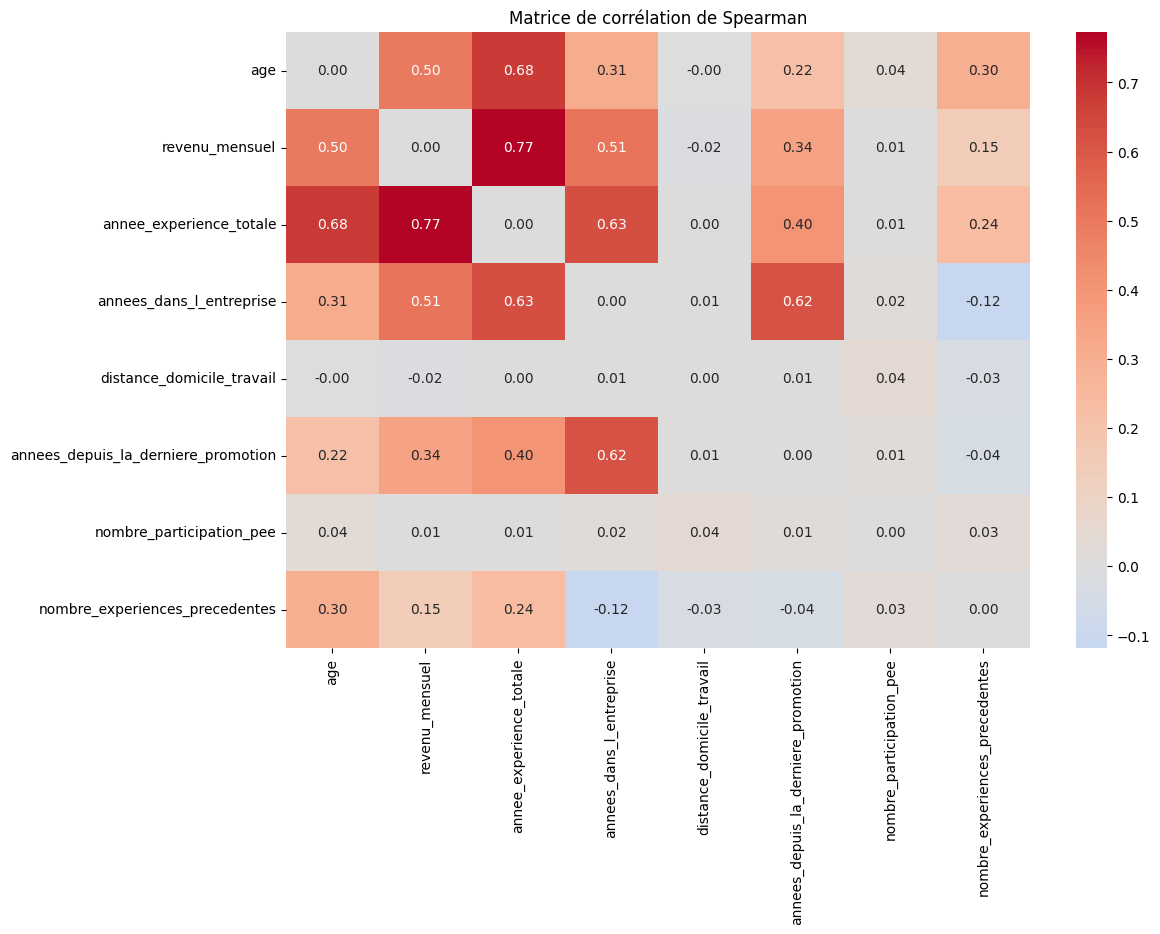

In [13]:
col_num = [
    'age','revenu_mensuel','annee_experience_totale',
    'annees_dans_l_entreprise','distance_domicile_travail','annees_depuis_la_derniere_promotion','nombre_participation_pee',
    'nombre_experiences_precedentes'
]
corr_donnees_features = donnees_features[col_num]
pearson_corr = corr_donnees_features.corr(numeric_only=True, method='pearson')
np.fill_diagonal(pearson_corr.values, 0)
plt.figure(figsize=(12, 8))
sns.heatmap(pearson_corr, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Matrice de corrélation de Spearman")
plt.show()

* Une relation assez forte entre le revenu_mensuel et annee_experience_totale, on décide de les garder pour le moement car ce sont des données importantes pour créer des features.

### Ajout de nouvelles variables

#### Reprenons notre DataFrame pour regarder les éléments que nous pouvons créer.

In [14]:
donnees_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 19 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   age                                       1470 non-null   int64 
 1   genre                                     1470 non-null   object
 2   revenu_mensuel                            1470 non-null   int64 
 3   statut_marital                            1470 non-null   object
 4   poste                                     1470 non-null   object
 5   nombre_experiences_precedentes            1470 non-null   int64 
 6   annee_experience_totale                   1470 non-null   int64 
 7   annees_dans_l_entreprise                  1470 non-null   int64 
 8   satisfaction_employee_environnement       1470 non-null   int64 
 9   satisfaction_employee_nature_travail      1470 non-null   int64 
 10  heure_supplementaires                     1470 n

#### Les features que nous voulons créer :
Avec les notions d'années :
* experience_externe = annee_experience_totale - annees_dans_l_entreprise

Avec les sondages :
* score_satisfaction = (satisfaction_employee_environnement + satisfaction_employee_nature_travail)/2

Avec le % d'augmentation :
* augmentation_par_formation = augmentation_salaire_precedente_pourcent / (nb_formations_suivies+1)

Avec le nombre_participation_pee :
* pee_par_anciennete = nombre_participation_pee / (annees_dans_l_entreprise+1)

### Création des calculs et ratios

#### Avec les notions d'années

In [15]:
donnees_features['experience_externe'] = donnees_features['annee_experience_totale'] - donnees_features['annees_dans_l_entreprise']

* experience_externe : nombre d'années dans une autre entreprise

* Petit récapitulatif

In [16]:
shape_donnees_features_un = donnees_features.shape
print("Nous avons", shape_donnees_features[0],"lignes et",shape_donnees_features[1],"colonnes avant transformation")
print("Nous avons", shape_donnees_features_un[0],"lignes et",shape_donnees_features_un[1],"colonnes après ajout d'une nouvelle variable experience_externe")

Nous avons 1470 lignes et 19 colonnes avant transformation
Nous avons 1470 lignes et 20 colonnes après ajout d'une nouvelle variable experience_externe


#### Avec les sondages

In [17]:
donnees_features['score_satisfaction'] = (donnees_features['satisfaction_employee_environnement'] + donnees_features['satisfaction_employee_nature_travail'])/2

* Petit check

In [18]:
donnees_features[['score_satisfaction','satisfaction_employee_environnement','satisfaction_employee_nature_travail']].head()

,score_satisfaction,satisfaction_employee_environnement,satisfaction_employee_nature_travail
0,3.0,2,4
1,2.5,3,2
2,3.5,4,3
3,3.5,4,3
4,1.5,1,2


In [19]:
donnees_features['score_satisfaction'].unique()

array([3. , 2.5, 3.5, 1.5, 4. , 2. , 1. ])

On peut donc supprimer les 2 autres sondages : satisfaction_employee_environnement & satisfaction_employee_nature_travail

In [20]:
donnees_features = donnees_features.drop(columns ='satisfaction_employee_environnement')
donnees_features = donnees_features.drop(columns ='satisfaction_employee_nature_travail')

* Petit récapitulatif

In [21]:
shape_donnees_features_deux = donnees_features.shape
print("Nous avons", shape_donnees_features[0],"lignes et",shape_donnees_features[1],"colonnes avant transformation")
print("Nous avons", shape_donnees_features_un[0],"lignes et",shape_donnees_features_un[1],"colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)")
print("Nous avons", shape_donnees_features_deux[0],"lignes et",shape_donnees_features_deux[1],"colonnes après ajout d'une variable sondage global & suppression des autres sondages")

Nous avons 1470 lignes et 19 colonnes avant transformation
Nous avons 1470 lignes et 20 colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)
Nous avons 1470 lignes et 19 colonnes après ajout d'une variable sondage global & suppression des autres sondages


#### Avec le % d'augmentation :

In [22]:
donnees_features['augmentation_par_formation'] = donnees_features['augmentation_salaire_precedente_pourcent'] / (donnees_features['nb_formations_suivies']+1)

* Petit récapitulatif

In [23]:
shape_donnees_features_trois = donnees_features.shape
print("Nous avons", shape_donnees_features[0],"lignes et",shape_donnees_features[1],"colonnes avant transformation")
print("Nous avons", shape_donnees_features_un[0],"lignes et",shape_donnees_features_un[1],"colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)")
print("Nous avons", shape_donnees_features_deux[0],"lignes et",shape_donnees_features_deux[1],"colonnes après ajout d'une variable sondage global")
print("Nous avons", shape_donnees_features_trois[0],"lignes et",shape_donnees_features_trois[1],"colonnes après ajout d'un indicateur d'augmentation")

Nous avons 1470 lignes et 19 colonnes avant transformation
Nous avons 1470 lignes et 20 colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)
Nous avons 1470 lignes et 19 colonnes après ajout d'une variable sondage global
Nous avons 1470 lignes et 20 colonnes après ajout d'un indicateur d'augmentation


### Avec le nombre_participation_pee :

In [24]:
donnees_features['pee_par_anciennete'] = donnees_features['nombre_participation_pee'] / (donnees_features['annees_dans_l_entreprise']+1)

* Petit récapitulatif

In [25]:
shape_donnees_features_quatre = donnees_features.shape
print("Nous avons", shape_donnees_features[0],"lignes et",shape_donnees_features[1],"colonnes avant transformation")
print("Nous avons", shape_donnees_features_un[0],"lignes et",shape_donnees_features_un[1],"colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)")
print("Nous avons", shape_donnees_features_deux[0],"lignes et",shape_donnees_features_deux[1],"colonnes après ajout d'une variable sondage global")
print("Nous avons", shape_donnees_features_trois[0],"lignes et",shape_donnees_features_trois[1],"colonnes après ajout de 2 indicateurs d'augmentation")
print("Nous avons", shape_donnees_features_quatre[0],"lignes et",shape_donnees_features_quatre[1],"colonnes après ajout d'une variable PEE")

Nous avons 1470 lignes et 19 colonnes avant transformation
Nous avons 1470 lignes et 20 colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)
Nous avons 1470 lignes et 19 colonnes après ajout d'une variable sondage global
Nous avons 1470 lignes et 20 colonnes après ajout de 2 indicateurs d'augmentation
Nous avons 1470 lignes et 21 colonnes après ajout d'une variable PEE


### Recommandation - Tracer un pairplot pour mesurer l’intensité des corrélations non-linéaires s’il y en a. Vous pouvez également compléter le pairplot avec une matrice de corrélation de Spearman.

#### Réalisation du pairplot selon notre cible

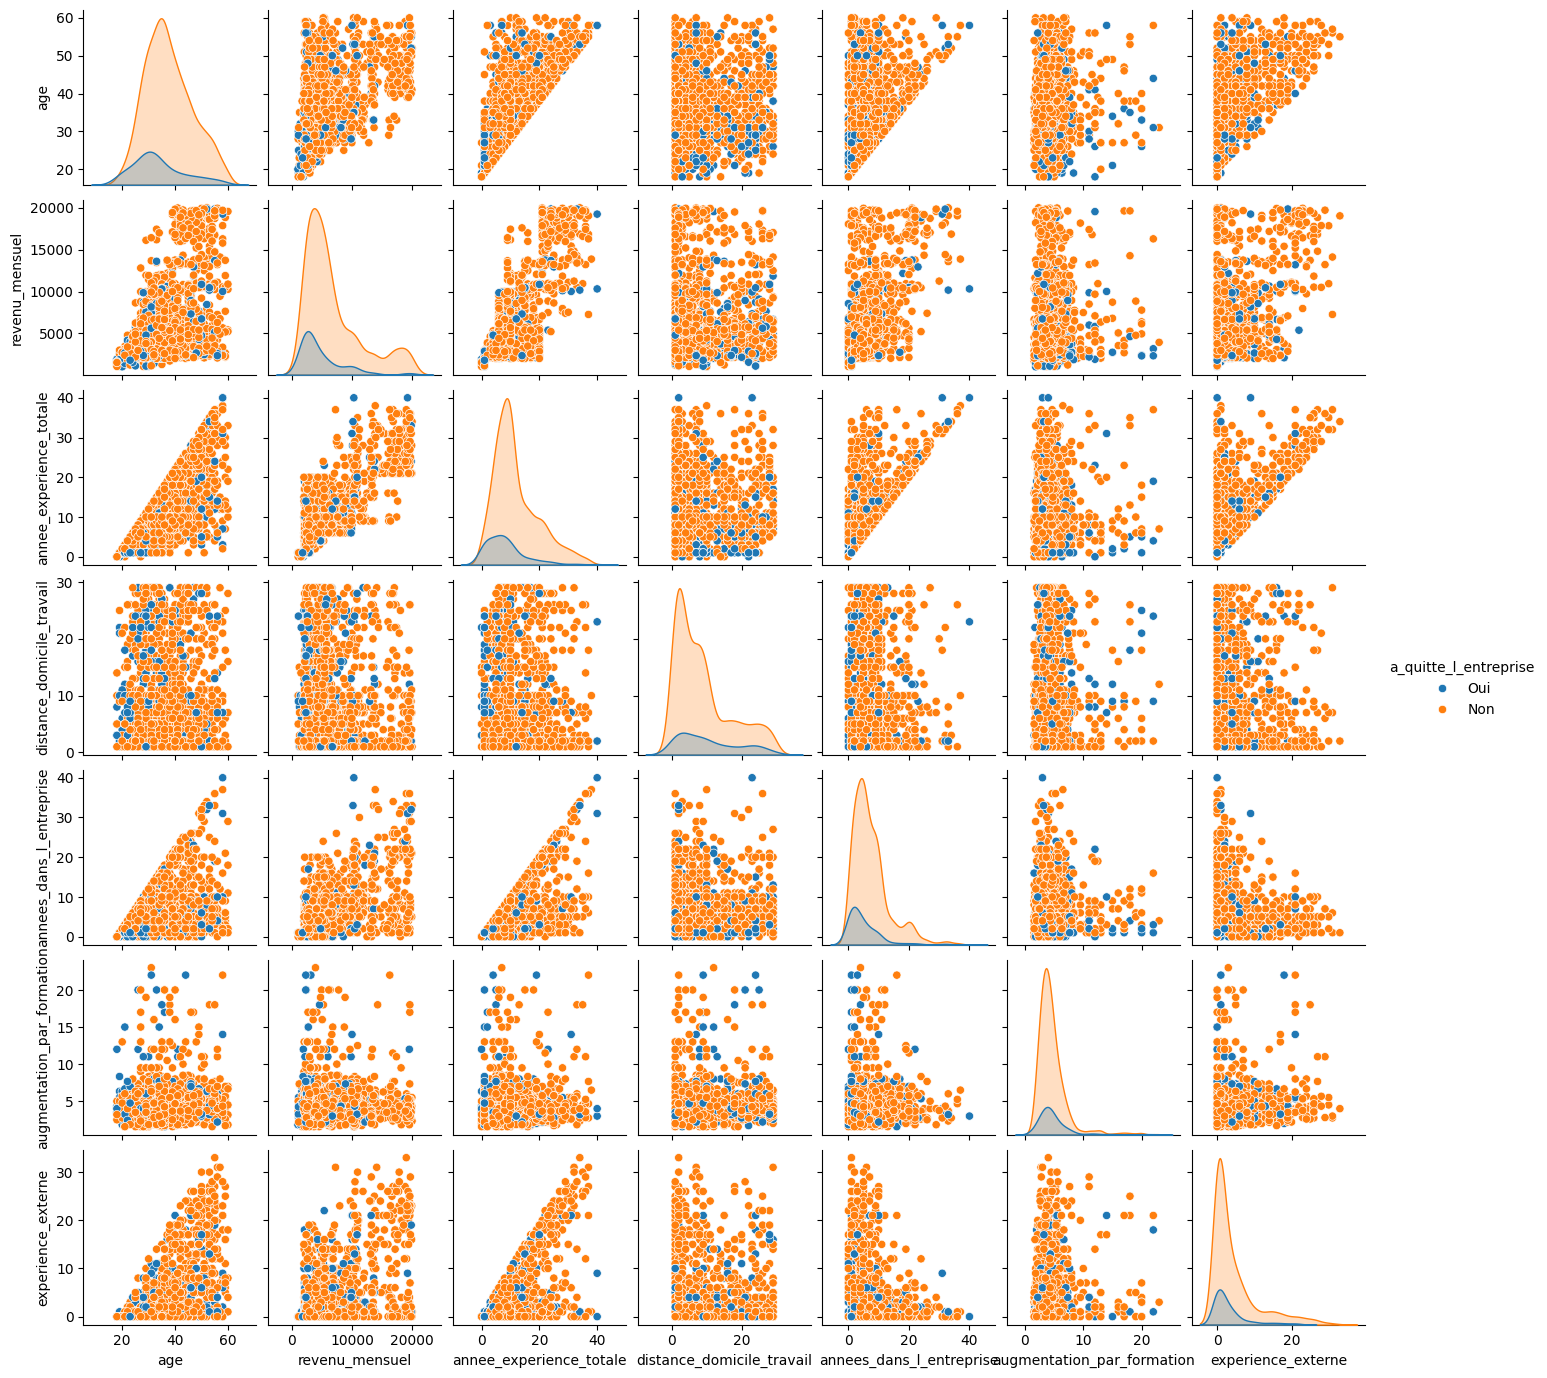

In [26]:
cols = [
    'age', 'revenu_mensuel', 'annee_experience_totale','distance_domicile_travail',
    'annees_dans_l_entreprise','a_quitte_l_entreprise','augmentation_par_formation','experience_externe'
    ]
data_pairplot = donnees_features[cols]

sns.pairplot(data_pairplot, hue = 'a_quitte_l_entreprise', height=2
)
plt.show()

### Après l'ajout de ces nouvelles variables, on peut regarder les relations entre elles.

In [27]:
col_num = [
    'age','revenu_mensuel','nombre_experiences_precedentes','annee_experience_totale',
    'annees_dans_l_entreprise','augmentation_salaire_precedente_pourcent','nombre_participation_pee','distance_domicile_travail',
    'annees_depuis_la_derniere_promotion','nb_formations_suivies','pee_par_anciennete','augmentation_par_formation','experience_externe',
    'score_satisfaction'
    ]
corr_donnees_rh = donnees_features[col_num]

#### Matrice de corrélation de Spearman

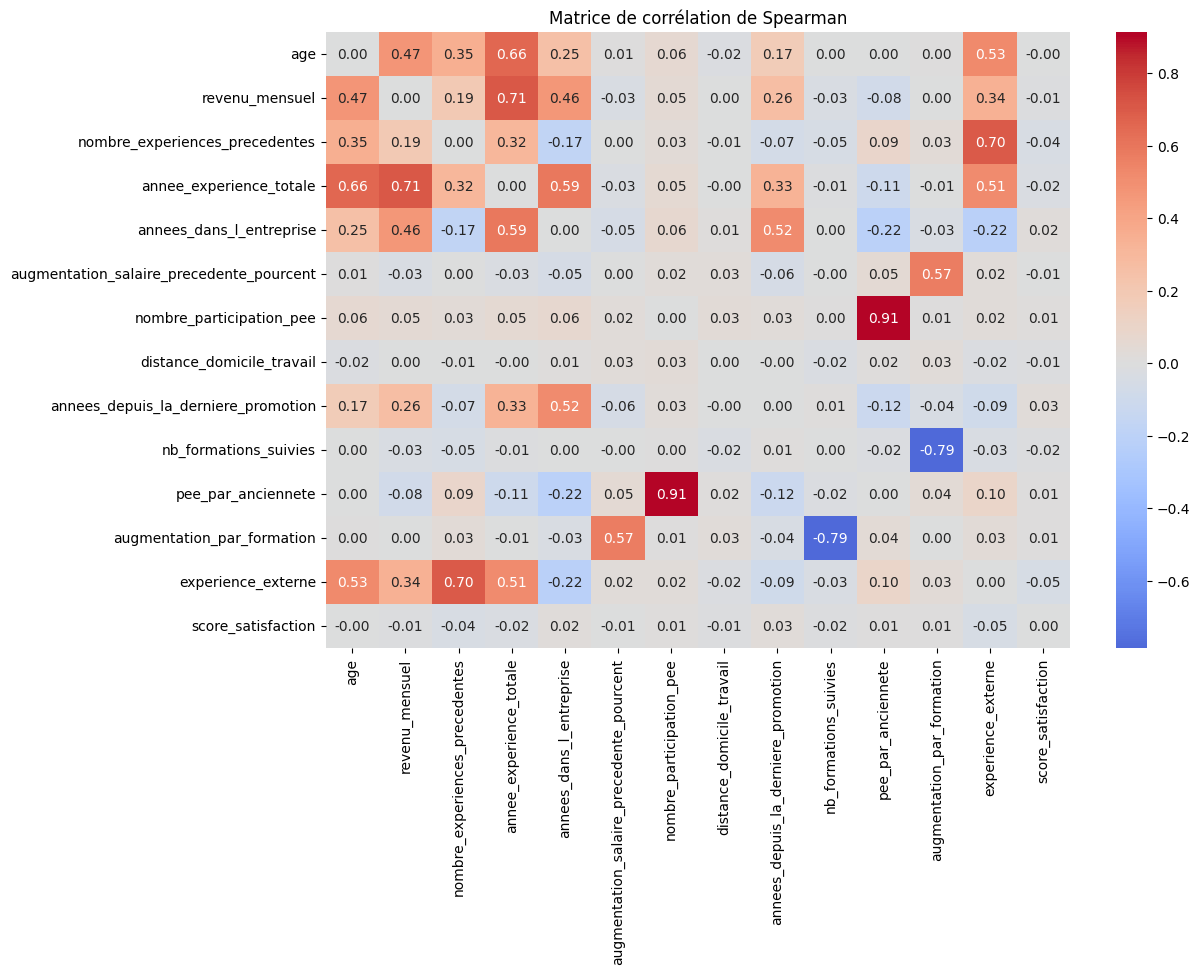

In [28]:
spearman_corr = corr_donnees_rh.corr(numeric_only=True, method='spearman')
np.fill_diagonal(spearman_corr.values, 0)
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Matrice de corrélation de Spearman")
plt.show()

On voit quelques variables correlés entres elles :
* Toujours une relation entre revenu et année totale mais moindre qu'avec le coefficient de Pearson. Nous sommes dans le cadre non linéaire, on va donc se baser sur ce coefficient, donc nous gardons les deux.
* Evidemment on retrouve une relation entre notre indicateur PEE et le nombre de participation PEE : nous allons supprimer le nombre de participation PEE
* Entre le nombre de formation et l'augmentation/formation, nous alons catégoriser la formation.
* On note une corrélation entre experience_externe & nombre_experiences_precedentes : suppression de nombre_experiences_precedentes

#### Suppression de nombre_participation_pee et nombre_experiences_precedentes

In [29]:
donnees_features = donnees_features.drop(columns='nombre_participation_pee')
donnees_features = donnees_features.drop(columns='nombre_experiences_precedentes')

In [30]:
shape_donnees_features_cinq = donnees_features.shape
print("Nous avons", shape_donnees_features[0],"lignes et",shape_donnees_features[1],"colonnes avant transformation")
print("Nous avons", shape_donnees_features_un[0],"lignes et",shape_donnees_features_un[1],"colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)")
print("Nous avons", shape_donnees_features_deux[0],"lignes et",shape_donnees_features_deux[1],"colonnes après ajout d'une variable sondage global")
print("Nous avons", shape_donnees_features_trois[0],"lignes et",shape_donnees_features_trois[1],"colonnes après ajout de 2 indicateurs d'augmentation")
print("Nous avons", shape_donnees_features_quatre[0],"lignes et",shape_donnees_features_quatre[1],"colonnes après ajout d'une variable PEE")
print("Nous avons", shape_donnees_features_cinq[0],"lignes et",shape_donnees_features_cinq[1],"colonnes après suppression de 2 colonnes redondantes")

Nous avons 1470 lignes et 19 colonnes avant transformation
Nous avons 1470 lignes et 20 colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)
Nous avons 1470 lignes et 19 colonnes après ajout d'une variable sondage global
Nous avons 1470 lignes et 20 colonnes après ajout de 2 indicateurs d'augmentation
Nous avons 1470 lignes et 21 colonnes après ajout d'une variable PEE
Nous avons 1470 lignes et 19 colonnes après suppression de 2 colonnes redondantes


#### Gestion de la colonne nb_formations_suivies

In [31]:
donnees_features["a_suivi_formation"] = (donnees_features["nb_formations_suivies"] >= 1).astype(int)

* Si 1 = a suivi une formation
* Si 0 = non

Suppression de la colonne nb_formations_suivies

In [32]:
donnees_features = donnees_features.drop(columns='nb_formations_suivies')

In [33]:
shape_donnees_features_six = donnees_features.shape
print("Nous avons", shape_donnees_features[0],"lignes et",shape_donnees_features[1],"colonnes avant transformation")
print("Nous avons", shape_donnees_features_un[0],"lignes et",shape_donnees_features_un[1],"colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)")
print("Nous avons", shape_donnees_features_deux[0],"lignes et",shape_donnees_features_deux[1],"colonnes après ajout d'une variable sondage global")
print("Nous avons", shape_donnees_features_trois[0],"lignes et",shape_donnees_features_trois[1],"colonnes après ajout de 2 indicateurs d'augmentation")
print("Nous avons", shape_donnees_features_quatre[0],"lignes et",shape_donnees_features_quatre[1],"colonnes après ajout d'une variable PEE")
print("Nous avons", shape_donnees_features_cinq[0],"lignes et",shape_donnees_features_cinq[1],"colonnes après suppression de 2 colonnes redondantes")
print("Nous avons", shape_donnees_features_six[0],"lignes et",shape_donnees_features_six[1],"colonnes après suppression de nb_formations_suivies et ajout de son binaire ")

Nous avons 1470 lignes et 19 colonnes avant transformation
Nous avons 1470 lignes et 20 colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)
Nous avons 1470 lignes et 19 colonnes après ajout d'une variable sondage global
Nous avons 1470 lignes et 20 colonnes après ajout de 2 indicateurs d'augmentation
Nous avons 1470 lignes et 21 colonnes après ajout d'une variable PEE
Nous avons 1470 lignes et 19 colonnes après suppression de 2 colonnes redondantes
Nous avons 1470 lignes et 19 colonnes après suppression de nb_formations_suivies et ajout de son binaire 


### Recommandation - Sélectionner une méthode d’encoding adaptée pour les features qualitatives en fonction de leur sens métier.

#### Création des tranches d'âge

In [34]:
# Je commence par effectuer mes tranches d'âge
donnees_features['tranche_age'] = pd.cut(donnees_features['age'], 
                        bins=[17, 30, 36, 43, 60], 
                        labels=['18-30', '31-36', '37-43','44+'])

# J'encode la colonne avec Label pour avoir des groupes distincts par groupe
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
donnees_features['tranche_age']= labelencoder.fit_transform(donnees_features['tranche_age'])

Je peux donc supprimer la colonne age

In [35]:
donnees_features = donnees_features.drop(columns='age')

#### Modification de la colonne genre

In [36]:
donnees_features['genre'] = donnees_features['genre'].map({'F': 1, 'M': 0})

#### Modification de la colonne statut marital avec OneHot

In [37]:
donnees_features = pd.get_dummies(donnees_features, columns=["statut_marital"], dtype=int)

* Petit récapitulatif

In [38]:
shape_donnees_features_sept = donnees_features.shape
print("Nous avons", shape_donnees_features[0],"lignes et",shape_donnees_features[1],"colonnes avant transformation")
print("Nous avons", shape_donnees_features_un[0],"lignes et",shape_donnees_features_un[1],"colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)")
print("Nous avons", shape_donnees_features_deux[0],"lignes et",shape_donnees_features_deux[1],"colonnes après ajout d'une variable sondage global")
print("Nous avons", shape_donnees_features_trois[0],"lignes et",shape_donnees_features_trois[1],"colonnes après ajout de 2 indicateurs d'augmentation")
print("Nous avons", shape_donnees_features_quatre[0],"lignes et",shape_donnees_features_quatre[1],"colonnes après ajout d'une variable PEE")
print("Nous avons", shape_donnees_features_cinq[0],"lignes et",shape_donnees_features_cinq[1],"colonnes après suppression de 2 colonnes redondantes")
print("Nous avons", shape_donnees_features_six[0],"lignes et",shape_donnees_features_six[1],"colonnes après suppression de nb_formations_suivies et ajout de son binaire ")
print("Nous avons", shape_donnees_features_sept[0],"lignes et",shape_donnees_features_sept[1],"colonnes après tranche d'âges et statut marital")

Nous avons 1470 lignes et 19 colonnes avant transformation
Nous avons 1470 lignes et 20 colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)
Nous avons 1470 lignes et 19 colonnes après ajout d'une variable sondage global
Nous avons 1470 lignes et 20 colonnes après ajout de 2 indicateurs d'augmentation
Nous avons 1470 lignes et 21 colonnes après ajout d'une variable PEE
Nous avons 1470 lignes et 19 colonnes après suppression de 2 colonnes redondantes
Nous avons 1470 lignes et 19 colonnes après suppression de nb_formations_suivies et ajout de son binaire 
Nous avons 1470 lignes et 21 colonnes après tranche d'âges et statut marital


#### Modification de heure_supplementaires

In [39]:
donnees_features['heure_supplementaires'] = donnees_features['heure_supplementaires'].map({'Oui': 1, 'Non': 0})

#### Suppression de augmentation_salaire_precedente_pourcent car difficilement interprétable et pas de relation proche de notre cible

In [40]:
donnees_features = donnees_features.drop(columns='augmentation_salaire_precedente_pourcent')

#### Modification de fréquence de déplacement

In [41]:
map_frequence = {"Aucun": 0, "Occasionnel": 1, "Frequent": 2}
donnees_features["frequence_deplacement"] = donnees_features["frequence_deplacement"].map(map_frequence)

#### Modification de annees_depuis_la_derniere_promotion
* Simplification des données (1 pour promotion récente (inférieure ou égale à 2ans))

In [42]:
donnees_features['promotion_recente'] = (donnees_features['annees_depuis_la_derniere_promotion'] <= 2).astype(int)

#### Changement pour la variable poste avec Onehot

In [43]:
donnees_features = pd.get_dummies(donnees_features, columns=["poste"], dtype=int)

#### Modification de notre cible 

In [45]:
donnees_features['a_quitte_l_entreprise'] = donnees_features['a_quitte_l_entreprise'].map({'Oui': 1, 'Non': 0})

In [46]:
donnees_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   genre                                1470 non-null   int64  
 1   revenu_mensuel                       1470 non-null   int64  
 2   annee_experience_totale              1470 non-null   int64  
 3   annees_dans_l_entreprise             1470 non-null   int64  
 4   heure_supplementaires                1470 non-null   int64  
 5   a_quitte_l_entreprise                1470 non-null   int64  
 6   distance_domicile_travail            1470 non-null   int64  
 7   niveau_education                     1470 non-null   int64  
 8   frequence_deplacement                1470 non-null   int64  
 9   annees_depuis_la_derniere_promotion  1470 non-null   int64  
 10  experience_externe                   1470 non-null   int64  
 11  score_satisfaction            

* Petit récapitulatif

In [44]:
shape_donnees_features_sept = donnees_features.shape
print("Nous avons", shape_donnees_features[0],"lignes et",shape_donnees_features[1],"colonnes avant transformation")
print("Nous avons", shape_donnees_features_un[0],"lignes et",shape_donnees_features_un[1],"colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)")
print("Nous avons", shape_donnees_features_deux[0],"lignes et",shape_donnees_features_deux[1],"colonnes après ajout d'une variable sondage global")
print("Nous avons", shape_donnees_features_trois[0],"lignes et",shape_donnees_features_trois[1],"colonnes après ajout de 2 indicateurs d'augmentation")
print("Nous avons", shape_donnees_features_quatre[0],"lignes et",shape_donnees_features_quatre[1],"colonnes après ajout d'une variable PEE")
print("Nous avons", shape_donnees_features_cinq[0],"lignes et",shape_donnees_features_cinq[1],"colonnes après suppression de 2 colonnes redondantes")
print("Nous avons", shape_donnees_features_six[0],"lignes et",shape_donnees_features_six[1],"colonnes après suppression de nb_formations_suivies et ajout de son binaire ")
print("Nous avons", shape_donnees_features_sept[0],"lignes et",shape_donnees_features_sept[1],"colonnes après tranche d'âges et statut marital")

Nous avons 1470 lignes et 19 colonnes avant transformation
Nous avons 1470 lignes et 20 colonnes après ajout de 2 nouvelles variables (annee_experience_totale & annees_dans_l_entreprise)
Nous avons 1470 lignes et 19 colonnes après ajout d'une variable sondage global
Nous avons 1470 lignes et 20 colonnes après ajout de 2 indicateurs d'augmentation
Nous avons 1470 lignes et 21 colonnes après ajout d'une variable PEE
Nous avons 1470 lignes et 19 colonnes après suppression de 2 colonnes redondantes
Nous avons 1470 lignes et 19 colonnes après suppression de nb_formations_suivies et ajout de son binaire 
Nous avons 1470 lignes et 29 colonnes après tranche d'âges et statut marital


#### Je sépare mon jeu de données et je standardise les éléments numériques non encodés

#### Je définis un nouveau DataFrame

In [47]:
donnees_modelisation = donnees_features

In [49]:
donnees_modelisation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 29 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   genre                                1470 non-null   int64  
 1   revenu_mensuel                       1470 non-null   int64  
 2   annee_experience_totale              1470 non-null   int64  
 3   annees_dans_l_entreprise             1470 non-null   int64  
 4   heure_supplementaires                1470 non-null   int64  
 5   a_quitte_l_entreprise                1470 non-null   int64  
 6   distance_domicile_travail            1470 non-null   int64  
 7   niveau_education                     1470 non-null   int64  
 8   frequence_deplacement                1470 non-null   int64  
 9   annees_depuis_la_derniere_promotion  1470 non-null   int64  
 10  experience_externe                   1470 non-null   int64  
 11  score_satisfaction            

Colonnes sous liste pour la modélisation